In order to re-execute data analysis please upload the hashtags.csv and scroll down to data analysis section.
Please don't run the data collection part again as this will only give 100 tweets because of the limitation imposed by Twitter on basic API level. Hashtags.csv consists of more than 1800 tweets collected using Academic Research level API access and those credentials have been removed for good reasons.

In [ ]:
# Environment setup
!pip install tweepy==4.12.0
!pip install emoji
!pip install flair

In [ ]:
#install required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tweepy # To extarct the twitter data
from tqdm import tqdm #progress bar
import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections.abc import Iterable

In [ ]:
import emoji
import flair
from flair.models import TextClassifier
sentiment_model = TextClassifier.load('en-sentiment')

2022-11-08 21:39:34,404 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


In [ ]:
#Twitter API authentication credentials
consumer_key = "CONSUMER_kEY"
consumer_secret = "CONSUMER_secret"
access_token = "ACCESS_TOKEN"
access_token_secret = "ACCESS_TOKEN_SECRET"
bearer_token="BEARER_TOKEN"

This function only works with Academic Research Access level and let us fetch more tweets data.

In [ ]:
def paginated_query(client):
  # Define query
  query = '(("#pepsi" "#lays") OR (#coke #lays) OR (#cocacola #lays)) lang:en -is:retweet -is:nullcast'

  paginator = tweepy.Paginator(
      method = client.search_all_tweets,
      limit=100,
      query=query,
      place_fields=['country','country_code','full_name','id','name','place_type'],
      expansions=['geo.place_id'],
      tweet_fields=['public_metrics','entities'],
      max_results=100,
      start_time='2022-01-01T00:00:0.0000Z',
      end_time='2022-11-01T00:00:00.000Z'
  )
  return paginator

In [ ]:
def query(client):
  # Define query
  query = '("#pepsi" "#lays") OR (#coke #lays) OR (#cocacola #lays) lang:en -is:retweet'

  # get max. 100 tweets
  tweets = client.search_recent_tweets(query=query,
                                      place_fields=['country','country_code','full_name','id','name','place_type'],
                                      expansions=['geo.place_id'],
                                      tweet_fields=['public_metrics','entities'],
                                      max_results=100)
  # Save data as dictionary
  tweets_dict = tweets.json()

  # Extract "data" value from dictionary
  tweets_data = tweets_dict['data']

  #Extract tweets expansions
  tweets_expansions = tweets_dict['includes']

  # Transform to pandas Dataframe
  # df = pd.json_normalize(tweets_data)
  return tweets_data, tweets_expansions

In [ ]:

def contains_hashtag(tweet_text, hashtags):
  hash_found = 0
  for hashtag in hashtags:
    hash_found = tweet_text.find(hashtag)
    return 1 if hash_found > -1 else 0

  return hash_found

def contains_hashtag_entity(tweet, brands):
  brand_status = 0
  entity_hashtags = None;
  if "entities" in tweet:
    if "hashtags" in tweet['entities']:
      entity_hashtags = tweet['entities']['hashtags']

  if len(brands) == 0 or entity_hashtags is None:
    return brand_status

  for brand in brands:
    for ehash_tag in entity_hashtags:
      if brand in ehash_tag['tag'].lower():
        brand_status = 1
        return brand_status

  return brand_status

def has_pepsi(tweet):
  tweet_text = tweet['text']
  pepsi_status = contains_hashtag_entity(tweet, ['Pepsi','pepsi'])
  if pepsi_status == 0:
    #pepsi not found in entity hashtags
    # try to find pepsi in tweet_text
    pepsi_status = contains_hashtag(tweet_text, ['Pepsi', 'pepsi',"pepsico",'pepsico','Pepsico','PepsiCo'])

  return pepsi_status

def has_coke(tweet):
  tweet_text = tweet['text']
  coke_status = contains_hashtag_entity(tweet, ['coke', 'cocacola'])
  if coke_status == 0:
    #coke not found in entity hashtags
    # try to find coke in tweet_text
    coke_status = contains_hashtag(tweet_text, ['Coke', 'Cocacola', 'CocaCola', 'coke', 'cocacola'])

  return coke_status

def has_lays(tweet):
  tweet_text = tweet['text']
  lays_status = contains_hashtag_entity(tweet, ['lays'])
  if lays_status == 0:
    #lays not found in entity hashtags
    # try to find lays in tweet_text
    lays_status = contains_hashtag(tweet_text, ['lays'])

  return lays_status

#return country code
def get_tweet_location(tweet, tweets_places):
  tweet_location = ""
  place_id = ""

  if "geo" in tweet:
    if "place_id" in tweet['geo']:
      place_id = tweet['geo']['place_id']

  if place_id and tweets_places:
    for tweet_place in tweets_places:
      if tweet_place['id'] == place_id:
        return tweet_place['country_code']

  return tweet_location

def remove_emojis(data):
  emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030""]+", re.UNICODE)
  return re.sub(emoj, '', data)

def clean_tweet_text(tweet):
  if 'RT' in tweet[:3]:
    tweet = tweet.replace('RT','')
    tweet = remove_emojis(tweet)
    tweet = tweet.replace(':','')
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = ''.join(c for c in tweet if c not in emoji.EMOJI_DATA) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text

  return tweet

def get_tweet_sentiment(tweet, tweet_dict):
  if tweet is None:
    return

  #clean tweet text for sentiment analysis
  tweet_text = clean_tweet_text(tweet['text'])
  #perform sentiment analysis on the cleaned tweet text - Flair/Bert
  sentence = flair.data.Sentence(tweet_text)
  sentiment_model.predict(sentence)
  tweet_dict['label'] = sentence.labels[0].value
  tweet_dict['numeric_score'] = sentence.labels[0].score

  return tweet_dict

def prepare_data(tweets_data, tweets_expansions):
  if tweets_data is None:
    return

  tweets_list = []
  tweet_dictionary = {}

  if isinstance(tweets_data, Iterable):
    for tweet in tweets_data:
      tweet_dictionary = {
          "tweet_id": tweet['id'] if tweet['id'] is not None else tweet['edit_history_tweet_ids'],
          "has_pepsi": has_pepsi(tweet),
          "has_coke": has_coke(tweet),
          "has_lays": has_lays(tweet),
          "tweet_likes": tweet['public_metrics']['like_count'],
          "tweet_retweets": tweet['public_metrics']['retweet_count']
          }
      if tweets_expansions is not None:
        if "places" in tweets_expansions:
          tweets_places = tweets_expansions['places']
          tweet_dictionary['tweet_location'] = get_tweet_location(tweet, tweets_places)
        else:
          tweet_dictionary['tweet_location'] = ""
      # once tweet is formatted add it to tweets_list
      tweet_dictionary = get_tweet_sentiment(tweet, tweet_dictionary)
      tweets_list.append(tweet_dictionary)
  #convert to dataframe
  t_df = pd.DataFrame(tweets_list)
  return t_df


These credentials can be used for basic access level and would only give a few hundred tweets.

In [ ]:
# Setting wait_on_rate_limit to True when initializing API will initialize an
# instance, called api here, that will automatically wait, using time.sleep,
# for the appropriate amount of time when a rate limit is encountered


client = tweepy.Client(bearer_token=bearer_token,
                        consumer_key=consumer_key,
                        consumer_secret=consumer_secret,
                        access_token=access_token,
                        access_token_secret=access_token_secret,
                        return_type = requests.Response,
                        wait_on_rate_limit=True)


#will only work with Academic research
# paginator = paginated_query(client)
tweets_data, tweets_expansions = query(client)
#prepare
t_df = prepare_data(tweets_data, tweets_expansions)
#savetoCSV
t_df.to_csv('hashtags_bk.csv',mode='a' ,index=False)

#will only work with Academic Research
# for tweets in paginator:
#   # Save data as dictionary
#   tweets_dict = tweets.json()
#   # Extract "data" value from dictionary
#   tweets_data = tweets_dict['data']
#   # Extract tweets expansions
#   tweets_expansions = None
#   if "includes" in tweets_dict:
#     tweets_expansions = tweets_dict['includes']
#   if tweets_data is not None and isinstance(tweets_data, Iterable):
#     # Prepare
#     t_df = prepare_data(tweets_data, tweets_expansions)
#     # save processed tweets data to CSV
#     t_df.to_csv('hashtags.csv',mode='a' ,index=False)

Load hashtags.csv and let's get started with **data analysis**

In [ ]:
#Load the data
df = pd.read_csv('hashtags.csv')

In [ ]:
df.head()

,tweet_id,has_pepsi,has_coke,has_lays,tweet_likes,tweet_retweets,tweet_location,label,numeric_score
0,1.587206e+18,1,0,0,1,0,NaN,NEGATIVE,0.999986
1,1.587177e+18,0,0,1,8,0,NaN,NEGATIVE,0.999738
2,1.587142e+18,1,0,0,0,0,NaN,NEGATIVE,0.859320
3,1.587102e+18,0,0,1,0,0,NaN,NEGATIVE,0.896805
4,1.586824e+18,1,0,0,3,0,NaN,POSITIVE,0.951139


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921 entries, 0 to 1920
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        1921 non-null   object
 1   has_pepsi       1921 non-null   object
 2   has_coke        1921 non-null   object
 3   has_lays        1921 non-null   object
 4   tweet_likes     1921 non-null   object
 5   tweet_retweets  1921 non-null   object
 6   tweet_location  463 non-null    object
 7   label           1921 non-null   object
 8   numeric_score   1523 non-null   object
dtypes: object(9)
memory usage: 135.2+ KB


In [ ]:
df.describe()

,tweet_id,has_pepsi,has_coke,has_lays,tweet_likes,tweet_retweets,numeric_score
count,1.831000e+03,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000
mean,1.520463e+18,0.582742,0.043146,0.305844,13.593119,2.544511,0.910915
std,3.282613e+16,0.493241,0.203241,0.460890,207.554891,25.735839,0.132099
min,1.477072e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.500985
25%,1.489033e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.871616
50%,1.515666e+18,1.000000,0.000000,0.000000,0.000000,0.000000,0.982757
75%,1.546458e+18,1.000000,0.000000,1.000000,2.000000,0.000000,0.998452
max,1.587206e+18,1.000000,1.000000,1.000000,8036.000000,686.000000,0.999997


In [ ]:
#replace missing location/country code with unk that stands for unknown
df.tweet_location = df.tweet_location.fillna('unk')

In [ ]:
# df['label'].replace(0,'NEGATIVE', True)
# df['label'].replace(1,'POSITIVE', True)

# df = df.drop(['tweet_id','tweet_location'], axis=1)
# headers = df.iloc[0]
# df = df[df["tweet_id"].str.contains("tweet_id") == False]
# df = df.drop(['tweet_id'], axis=1)

The tweets data that I could gather from twitter for hashtag analysis contains around 2000 tweets from different countries.
Below swarm plot depicts the distribution of data across
known and unknown (unk) places.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 84.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


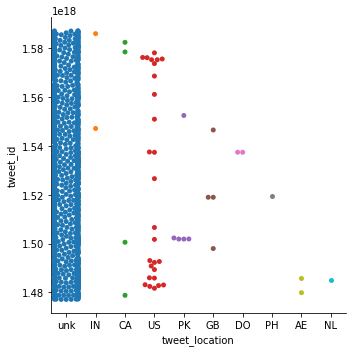

In [ ]:
sns.catplot(data=df, x="tweet_location", y="tweet_id",kind="swarm")

The following graph shows distribution of positive and negative sentiments and which kind of information is getting more likes. This is evident from the graph below tweets with negative sentiments are getting more likes/attention.

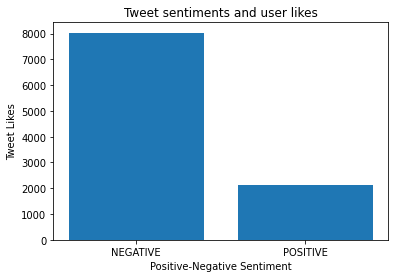

In [ ]:
plt.bar(df['label'], df['tweet_likes'])
plt.title('Tweet sentiments and user likes')
plt.xlabel('Positive-Negative Sentiment')
plt.ylabel('Tweet Likes')
plt.show()

The following graph shows distribution of positive and negative sentiments and which kind of information is getting more retweets. This is evident from the graph below tweets with negative sentiments spread faster than positive ones.

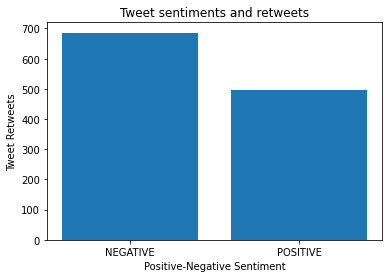

In [ ]:
plt.bar(df['label'], df['tweet_retweets'])
plt.title('Tweet sentiments and retweets')
plt.xlabel('Positive-Negative Sentiment')
plt.ylabel('Tweet Retweets')
plt.show()

An overview of total number of positive and negative tweets the dataset have. It can be seen the data is rather balanced in terms
of positive and  negative tweets about the hashtags #pepsi #coke #lays.

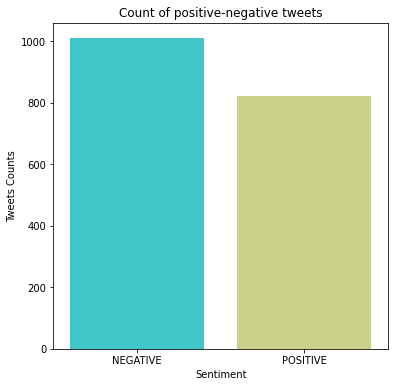

In [ ]:
plt.figure(figsize=(6,6))
ax=sns.countplot(x='label',data=df, palette='rainbow')
ax.set(xlabel='Sentiment', ylabel='Tweets Counts')
plt.title("Count of positive-negative tweets")
plt.show()

The following graph shows how many tweets do we have that contains #pepsi or pepsi as a word in tweet text. The search was
broadend to cater for whole tweet text and to increase the sample size. Because Twitter API does not guarntee to return only those tweets that contains #pepsi but we also get tweets that contains the pepsi as a word inside text.

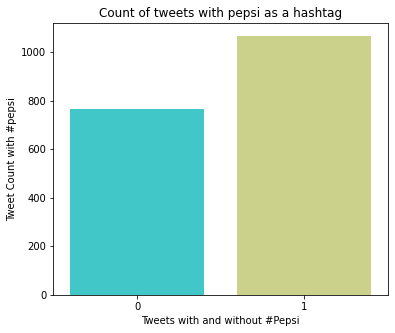

In [ ]:
plt.figure(figsize=(6,5))
# sns.histplot(data=penguins, x="flipper_length_mm")
chart = sns.countplot(x='has_pepsi',data=df, palette='rainbow')
chart.set(xlabel='Tweets with and without #Pepsi', ylabel='Tweet Count with #pepsi')
plt.title("Count of tweets with pepsi as a hashtag")
plt.show()

Althought we queried for all hashtags but the data for hashtags #coke and #cocacola could not be gathered in sufficient quantity.
This might pose a biased on the analysis. but we are continuing with the analysis and this aspect can be considered on a later stage.

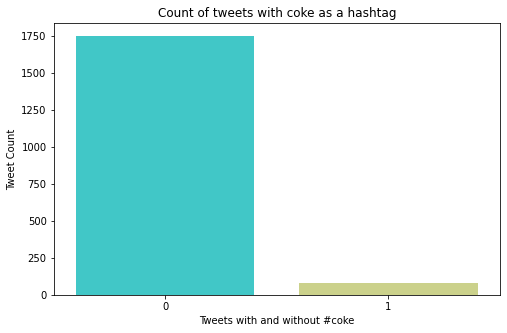

In [ ]:
plt.figure(figsize=(8,5))
chart = sns.countplot(x='has_coke',data=df, palette='rainbow')
chart.set(xlabel='Tweets with and without #coke', ylabel='Tweet Count')
plt.title("Count of tweets with coke as a hashtag")
plt.show()

We have around 500 tweets that contains #lays

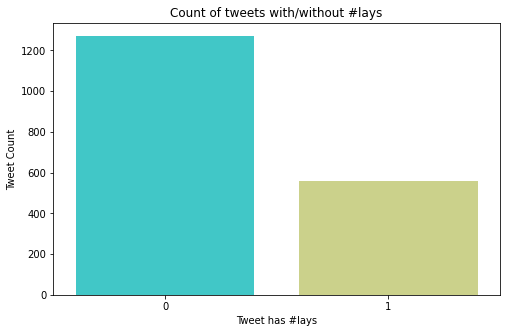

In [ ]:
plt.figure(figsize=(8,5))
chart = sns.countplot(x='has_lays',data=df, palette='rainbow')
chart.set(xlabel='Tweet has #lays', ylabel='Tweet Count')
plt.title("Count of tweets with/without #lays")
plt.show()

Following distribution plot shows the distribution of retweets in relation to sentiment while highlighting the total volume of tweets per category.

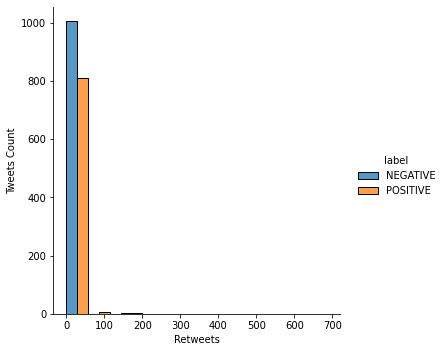

In [ ]:
ax = sns.displot(df, x="tweet_retweets", hue="label", multiple="dodge")
ax.set(xlabel='Retweets', ylabel='Tweets Count')
plt.show()

The following plot shows distribution of likes across tweets that
has #pepsi or the word pepsi inside tweet text while taking sentiment of the tweet into consideration. It can be clearly seen
that tweets that has a negative sentiment and are associated with pepsi they have higher possibility of being liked. That shows a serious problem with how users are perceiving pepsi's brand position based on the tweet content.

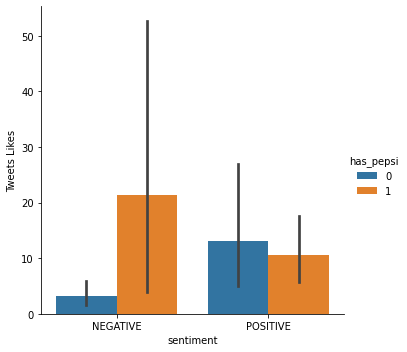

In [ ]:
ax=sns.catplot(data=df, x="label", y="tweet_likes", hue="has_pepsi", kind="bar")
ax.set(xlabel='sentiment', ylabel='Tweets Likes')
plt.show()

Indicates volumn of tweets that contains #pepsi and #lays
The following plot shows #pepsi and #lays in combination and it can be seen that we have around 300 tweets that contains both #pepsi and #lays hashtags.

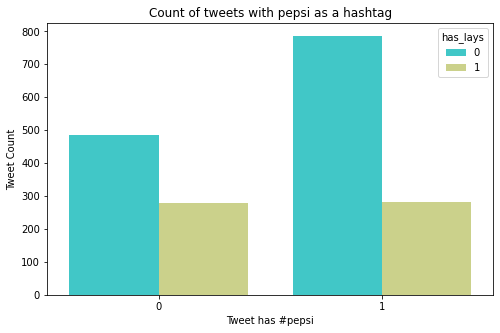

In [ ]:
plt.figure(figsize=(8,5))
chart = sns.countplot(x='has_pepsi',data=df, palette='rainbow', hue='has_lays')
chart.set(xlabel='Tweet has #pepsi', ylabel='Tweet Count')
plt.title("Count of tweets with pepsi as a hashtag")
plt.show()

Indicates volumn of tweets that contains #coke and #lays
The following plot shows #coke and #lays in combination and it can be seen that we have less than 100 tweets that contains both #coke and #lays hashtags.

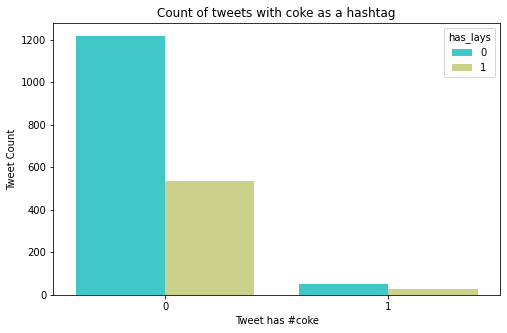

In [ ]:
plt.figure(figsize=(8,5))
chart = sns.countplot(x='has_coke',data=df, palette='rainbow', hue='has_lays')
chart.set(xlabel='Tweet has #coke', ylabel='Tweet Count')
plt.title("Count of tweets with coke as a hashtag")
plt.show()

The following graph explains user behaviour of liking a tweet based on the #pepsi and #lays and the tweet's sentiment. It can be seen that tweets associated with #lays are generally taken positive and earn more likes as compared to #pepsi. Where as #pepsi has some sort of negative sentiment associated with them that affects the tweets likes when they appear together. This can be seen in fourth graph bottom right when both tags appear together the negative sentiment for #lays shows slight growth, positive sentiment is affected badly hence tweet likes went down.
That shows a negative sign of combining these two brands for marketing and sales targets.

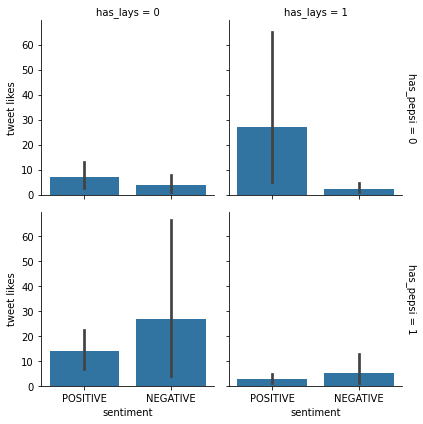

In [ ]:
g = sns.FacetGrid(df, row="has_pepsi", col="has_lays", margin_titles=True)
g.map(sns.barplot, "label", "tweet_likes", order=["POSITIVE", "NEGATIVE"]).set_axis_labels('sentiment','tweet likes')

The following graph explains user behaviour of liking a tweet based on the #coke and #lays and the tweet's sentiment. It can be seen that tweets associated with #lays are generally taken positive and earn more likes as compared to #coke. Whereas #coke also has slightly negative sentiment associated with it. However when both #coke and #lays are combined they perform really better in terms of sentiment we can see a decrease in negative sentiment for #lays and an increase in #coke. That makes them a potential duo that can perform better when placed together in terms of marketing and sales.

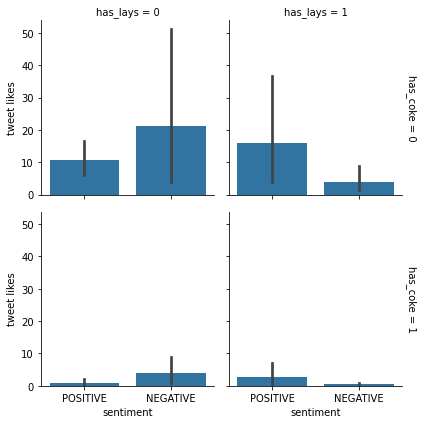

In [ ]:
g = sns.FacetGrid(df, row="has_coke", col="has_lays", margin_titles=True)
g.map(sns.barplot, "label", "tweet_likes", order=["POSITIVE", "NEGATIVE"]).set_axis_labels('sentiment','tweet likes')

The following graph explains user behaviour of retweeting a tweet based on the #coke and #lays and the tweet's sentiment. It can be seen that tweets associated with #lays are generally taken positive and earn more retweets as compared to #coke. Where as #coke has slight negative sentiment associated with them that affects the tweet chances of getting retweeted when they appear together. This can be seen in fourth graph bottom right when both tags appear together the negative sentiment of the tweet increases and the spread of tweets with negative sentiment also increases that affects the brand reputation. Hence combining these two tags show a negative relation and does not support in marketing and sales targets.

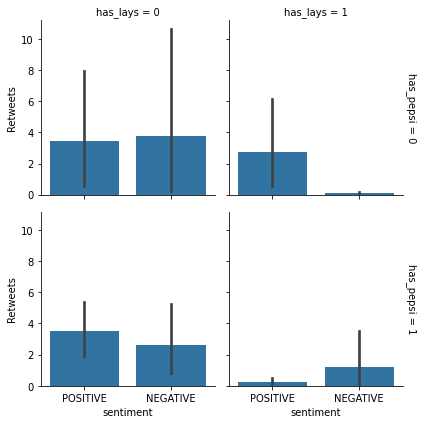

In [ ]:
g = sns.FacetGrid(df, row="has_pepsi", col="has_lays", margin_titles=True)
g.map(sns.barplot, "label", "tweet_retweets", order=["POSITIVE", "NEGATIVE"]).set_axis_labels('sentiment','Retweets')

The following graph explains user behaviour of retweeting a tweet based on the #coke or #cocacola and #lays and the tweet's sentiment. It can be seen that tweets associated with #lays are generally taken positive and earns more retweets.

And when they both are combined together the graph shows growth in positive sentiment of tweets that leads to more spread of the information that is more retweets. We can infer based on available dataset that combining #coke and #lays can reach more audience and positively support marketing and sales goals.

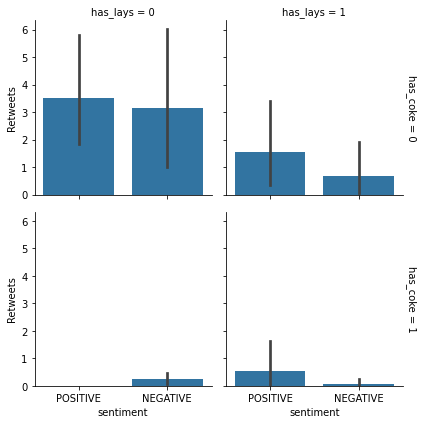

In [ ]:
g = sns.FacetGrid(df, row="has_coke", col="has_lays", margin_titles=True)
g.map(sns.barplot, "label", "tweet_retweets", order=["POSITIVE", "NEGATIVE"]).set_axis_labels('sentiment','Retweets')

In [ ]:
# Show distribution of tweets over positive and negative sentiments

#show individual hash tag graphs

#show lays - pepsi pair graph with likes or re-tweets and all other combinations